In this short notebook, we will give a few examples on how to use the $E(B-V)$ map provided in Lenz, Hensley & Doré (2017). We distribute this map in the HEALPix format ([Górski et al. 2005](http://adsabs.harvard.edu/abs/2005ApJ...622..759G)), so [`healpy`](http://healpy.readthedocs.io/en/latest/) needs to be installed. Moreover, we use [`astropy`](http://astropy.org) for coordinate conversions.

In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # for high-resolution displays e.g. newer MacBooks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
from __future__ import print_function
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Loading and inspecting the map

Make sure you [download](www.daniellenz.blog/data) the reddening map.

In [130]:
ebv_map = hp.read_map('ebv_lhd.hpx.fits', verbose=False)

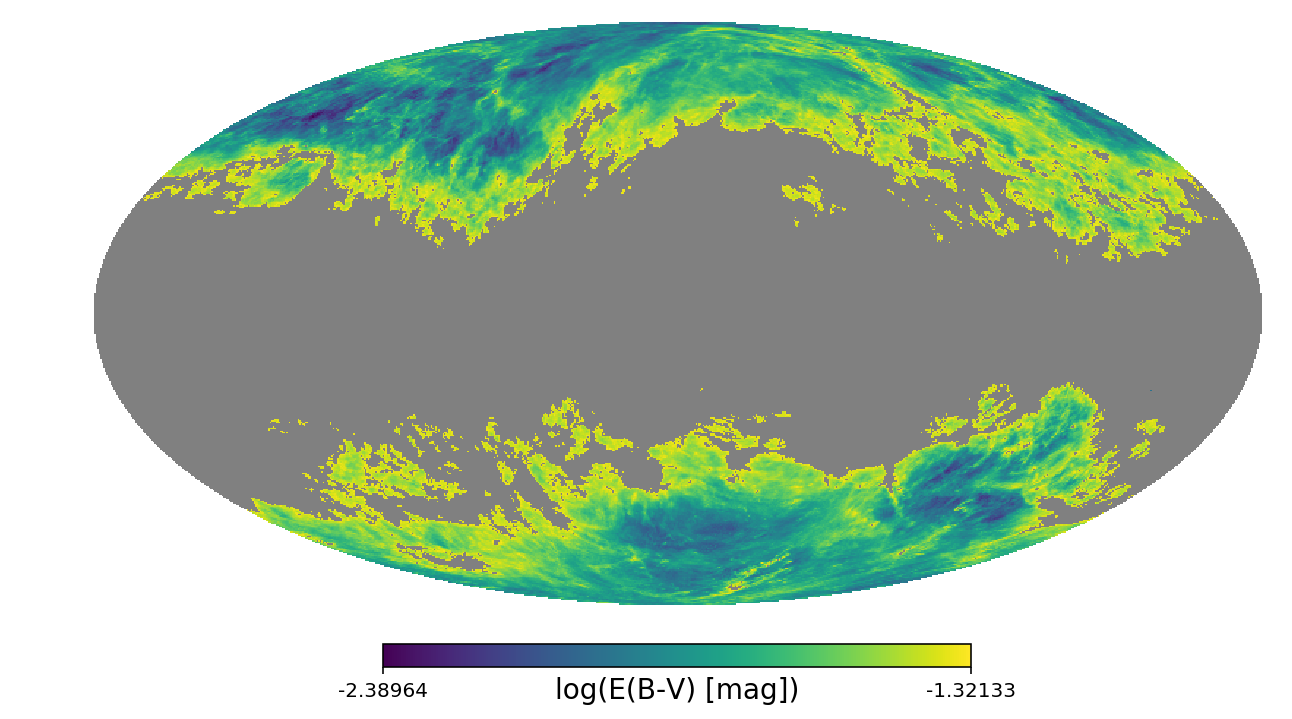

In [131]:
hp.mollview(np.log10(ebv_map), title='', unit='log(E(B-V) [mag])')

# Setting basic healpix parameters

The HEALPix tessellation is fully defined by the nside of the map and the ordering.

In [132]:
nside = hp.get_nside(ebv_map)
npix = hp.nside2npix(nside)
ordering = 'ring'

# Reddening for a particular line of sight

We demonstrate how to use the $E(B-V)$ map and some basic python to extract reddenings along particular lines of sight.

In [133]:
def line_of_sight(lon, lat, coord='Galactic'):
    """
    Computes the reddening along a particular line of sight
    
    Input
    -----
    
    lon : float or 1D-array
        Input longitude in degree
    lat : float or 1D-array
        Input latitude in degree
    coord : 'Galactic' or 'ICRS', defaults to 'Galactic'
        Coordinate system in which lon and lat is evaluated
    
    Returns
    -------
    ebv_los : float or 1D-array
        Reddenings in mag along the line of sight.
        If the returned values are `np.nan`, then the map does not cover this part of the sky

    """
    if coord.lower() == 'icrs':
        s = SkyCoord(
            ra=lon * u.degree,
            dec=lat * u.degree,
            frame='icrs')
        s_gal = s.galactic
        glon = s_gal.l.value
        glat = s_gal.b.value
        print('#####################')
        print('Converted R.A/Dec to l/b, Galactic coordinates are:')
        print('Gal. lon\t Gal. lat')
        print(np.column_stack((glon, glat)))
        print('#####################')
        
    else:
        glon = lon
        glat = lat
    
    # get pixel numbers
    pix = hp.ang2pix(nside, glon, glat, lonlat=True)
    
    # get reddening for these pixels
    ebv_los = ebv_map[pix]

    return ebv_los

In [134]:
ra, dec = [200, 110], [80, 65]
print('E(B-V) for R.A. = {ra}, Dec={dec}:'.format(ra=ra, dec=dec))
print('E(B-V):', line_of_sight(ra, dec, coord='icrs'))

E(B-V) for R.A. = [200, 110], Dec=[80, 65]:
#####################
Converted R.A/Dec to l/b, Galactic coordinates are:
Gal. lon	 Gal. lat
[[ 121.38232114   37.04216525]
 [ 151.11417292   27.38809308]]
#####################
E(B-V): [ 0.03016265         nan]


Note that `np.nan` means that this line of sight is not covered by the reddening map. All reddening values are in magnitudes.

In [135]:
glon, glat = [200, 110], [80, 65]
print('E(B-V) for l={glon}, b={glat}:'.format(glon=glon, glat=glat))
print('E(B-V):', line_of_sight(glon, glat, coord='galactic'))

E(B-V) for l=[200, 110], b=[80, 65]:
E(B-V): [ 0.01704503  0.00873742]


# Converting reddening to extinction

Following the work by [Schlafly & Finkbeiner (2011, hereafter SF11)](http://adsabs.harvard.edu/abs/2011ApJ...737..103S), we demonstrate how to convert the measured reddening values to extinction $A_{\lambda}$ in different bandpasses.
We begin by loading Table 6 from SF11.

In [136]:
ebv2A_lambda_df = pd.read_table('conversions.txt', comment='#', index_col=0)

In [137]:
ebv2A_lambda_df.head(10)

,lambda_eff,2.1,3.1,4.1,5.1
Bandpass,,,,,
Landolt U,3508.2,5.614,4.334,3.773,3.460
Landolt B,4329.0,4.355,3.626,3.290,3.096
Landolt V,5421.7,2.953,2.742,2.645,2.589
Landolt R,6427.8,2.124,2.169,2.189,2.201
Landolt I,8048.4,1.410,1.505,1.548,1.573
CTIO U,3733.9,5.170,4.107,3.628,3.355
CTIO B,4308.9,4.382,3.641,3.300,3.104
CTIO V,5516.6,2.857,2.682,2.600,2.553
CTIO R,6520.2,2.055,2.119,2.149,2.166


We are only intersted in the column for $R_V=3.1$, hence we can ignore the other columns. The available filters for which we can infer the extinction, based on a measured $E(B-V)$ value, are the following:

In [138]:
ebv2A_lambda_df.index

Index(['Landolt U', 'Landolt B', 'Landolt V', 'Landolt R', 'Landolt I',
       'CTIO U', 'CTIO B', 'CTIO V', 'CTIO R', 'CTIO I', 'UKIRT J', 'UKIRT H',
       'UKIRT K', 'UKIRT L"', 'Gunn g', 'Gunn r', 'Gunn i', 'Gunn z',
       'Spinrad R_S', 'Stromgren u', 'Stromgren b', 'Stromgren v',
       'Stromgren beta', 'Stromgren y', 'SDSS u', 'SDSS g', 'SDSS r', 'SDSS i',
       'SDSS z', 'DSS-II g', 'DSS-II r', 'DSS-II i', 'PS1 g', 'PS1 r', 'PS1 i',
       'PS1 z', 'PS1 y', 'PS1 w', 'LSST u', 'LSST g', 'LSST r', 'LSST i',
       'LSST z', 'LSST y', 'WFPC2 F300W', 'WFPC2 F450W', 'WFPC2 F555W',
       'WFPC2 F606W', 'WFPC2 F702W', 'WFPC2 F814W', 'WFC3 F105W', 'WFC3 F110W',
       'WFC3 F125W', 'WFC3 F140W', 'WFC3 F160W', 'WFC3 F200LP', 'WFC3 F218W',
       'WFC3 F225W', 'WFC3 F275W', 'WFC3 F300X', 'WFC3 F336W', 'WFC3 F350LP',
       'WFC3 F390W', 'WFC3 F438W', 'WFC3 F475W', 'WFC3 F475X', 'WFC3 F555W',
       'WFC3 F600LP', 'WFC3 F606W', 'WFC3 F625W', 'WFC3 F775W', 'WFC3 F814W',
       'WFC3 F8

In [139]:
def ebv2A_lambda(ebv, bandpass):
    """
    Converts reddening to extinction in a given
    bandpass, following the values of Schlafy & Finkbeiner (2011, Table 6)
    
    Input
    -----
    ebv : float or ndarray
        Input reddening value or vector
    bandpass : str
        Bandpass for which the extinction is computed. Must be
        part of Schlafly & Finkbeiner (2011, Table 6)
        
    Returns
    -------
    A_lambda : float or ndarray
        Extinction in the selected band, has same shape as input ebv
    
    """

    factor = ebv2Alambda_df['3.1'][bandpass]
    A_lambda = ebv * factor

    return A_lambda

Testing the conversion for individual values:

In [140]:
# 50 mmag
ebv2A_lambda(0.05, 'SDSS g')

0.16515000000000002

In [141]:
# The entire E(B-V) map
A_r_map = ebv2A_lambda(ebv_map, 'SDSS r')

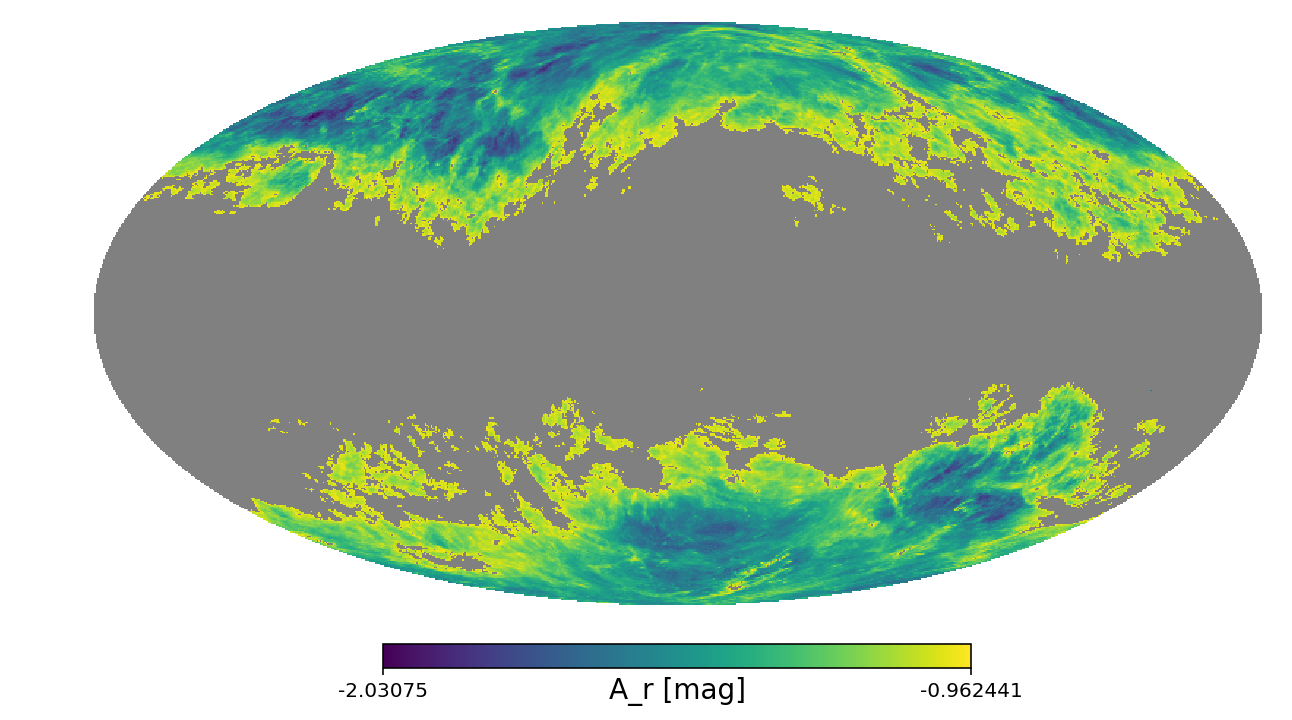

In [142]:
hp.mollview(np.log10(A_r_map), title='', unit='A_r [mag]')